### Importing the Necessary Libraries

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import cv2
from matplotlib import pyplot as plt

2023-12-12 19:39:46.417453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Image Classifier Model 

In [2]:
# Load our image classifier model
model_path = 'imageclassifer_model.h5' 
model = keras.models.load_model(model_path)

### Generating an Adversarial Example

In [122]:
# Function to generate an adversarial example using projected gradient descent
def generate_adversarial_example(model, image, target_label, epsilon=0.1, iterations=100):
    image = tf.convert_to_tensor(image)

    for i in range(iterations): # Since this is an iterative optimization-based attack
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = model(image)
            loss = tf.keras.losses.BinaryCrossentropy()(target_label, prediction) # Computes the cross-entropy loss between true labels and predicted labels.

        gradient = tape.gradient(loss, image)
        perturbation = epsilon * tf.sign(gradient) # Multiplying the hyperparameter by thr gradient
        perturbation = tf.clip_by_value(perturbation, 0, 1)  # Make sure values are in [0, 1] since this is a binary classifier
        adversarial_image = image + perturbation # Add perturbation to original image 
        adversarial_image = tf.clip_by_value(adversarial_image, 0, 1) # Make sure values are in [0, 1]

    adversarial_prediction = model.predict(adversarial_image) # Using the model to predict adversarial image
    adversarial_class = tf.argmax(adversarial_prediction[0])

    return adversarial_image.numpy(), adversarial_class.numpy()

In [123]:
# Set the target label for the adversarial example (0 for number and 1 for shape)
target_label = np.array([0.0])

In [124]:
# This is to make sure the target_label has the same shape as the prediction
target_label = tf.convert_to_tensor(target_label, dtype=tf.float32)

### Generating an Example Using a Test Image 

In [125]:
# Load and preprocess a test image 
test_image_path = '/Users/AyaHourani 1/Desktop/numbers_test.jpeg'
img = cv2.imread(test_image_path)
resize = tf.image.resize(img, (256, 256))
input_image = np.expand_dims(resize / 255, 0)

In [126]:
# Generate adversarial example
adversarial_image, adversarial_class = generate_adversarial_example(model, input_image, target_label)

1/1 [==============================] - 0s 23ms/step


In [127]:
# Check the predictions for both the original and adversarial images
original_prediction = model.predict(input_image)
adversarial_prediction = model.predict(adversarial_image)

if original_prediction[0] > 0.5:
    original_label = 'shape'
else:
    original_label = 'number'
    
if adversarial_prediction[0] > 0.5:
    adversarial_label = 'shape'
else:
    adversarial_label = 'number'

print("Original Prediction:", original_prediction)
print("Adversarial Prediction:", adversarial_prediction)


1/1 [==============================] - 0s 22ms/step
Original Prediction: [[0.03178492]]
Adversarial Prediction: [[0.99996257]]


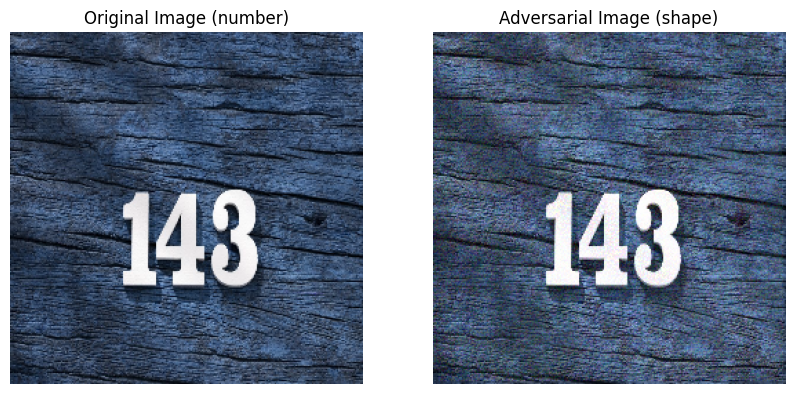

In [128]:
# Display the original and adversarial images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title(f"Original Image ({original_label})")
plt.imshow(resize.numpy().astype(int))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Adversarial Image ({adversarial_label})")
plt.imshow(adversarial_image[0])
plt.axis("off")

plt.show()